# Visibility-based EoR Power Spectrum Test Case - SRCNet v0.1
---

**Test name:** SWF-008-T2 - Visibility-based EoR power spectrum estimation

**Author:** Jacob Burba and Teal Team

**Documentation on confluence:** [https://confluence.skatelescope.org/x/o2FoEw](https://confluence.skatelescope.org/x/o2FoEw)

**Summary:** This test assesses the ability of SRCNet v0.1 to perform a visibility-based EoR power spectrum analysis.  In this particular test, we use `hydra-pspec`, a Bayesian EoR power spectrum estimation framework that is being actively developed.  We walk through all of the steps required to run a `hydra-pspec` analysis and demonstrate the results of analyzing a set of simulated visibilities with a known input EoR power spectrum.

---

## Data

This notebook uses a set of simulated visibilities containing a mock EoR signal and foregrounds.  For details about the simulated data used in this notebook, please see section 3 of [Burba et al. 2024](https://ui.adsabs.harvard.edu/abs/2024MNRAS.535..793B/abstract).

## In this test we perform

- Reading of visibilities in uvfits format with `pyuvdata`
- Power spectrum estimation using `hydra-pspec`
- Cylindrical and spherical binning of `hydra-pspec` results
- Compare the cylindrical and spherical power spectrum estimates with the counterparts calculated directly from the input EoR-only visibilities

## Expected outputs

- Plot of cylindrically-averaged power spectrum (Figure 9)
- Plot of spherically-averaged power spectrum (Figure 10)

## Validation

The outputs can be verified by comparing figures 9 and 10 with their matching figures on [confluence](https://confluence.skatelescope.org/x/o2FoEw).

In [1]:
import numpy as np
from astropy import units
from astropy.constants import c
from astropy.cosmology import Planck18
from astropy.units import Quantity
from astropy.time import Time
from pathlib import Path
from pyuvdata import UVData
from pyuvdata import utils as uvutils
from pyuvdata.analytic_beam import AiryBeam
from scipy.signal.windows import blackmanharris
import time

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm, LogNorm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import ImageGrid

import hydra_pspec
print(f"{hydra_pspec.__version__ = }")

hydra_pspec.__version__ = '1.5.1.dev12+gc9ed27c'


In [2]:
plt.rcParams["font.size"] = 14
plt.rcParams["image.interpolation"] = "None"
plt.rcParams["figure.facecolor"] = "w"

# User parameter definitions

In [3]:
# Path to the directory containing the required visibility files:
# - eor.uvfits
# - foregrounds.uvfits
data_path = Path(
    "/home/jburba/hydra_team/uksrc/srcnet-test-campaigns/SWF-008-T2/data/"
)

# Signal-to-noise ratio in delay power spectrum space for the EoR and noise.
# This determines the strength of the detection in this notebook as we are
# using simulated visibilities and the noise is generated as white noise
# visibilities.  The standard deviation of the noise is baseline dependent and
# chosen based upon the amplitude of the mock EoR delay power spectrum which,
# for these simulated data, is flat.  This gaurantees that each delay bin has
# approximately the same SNR = snr_dps.
snr_dps = 50

# Number of foreground model basis vectors to use in the analysis.  This
# equates to the number of eigenvectors derived from the freq-freq covariance
# of the foreground visibilities used in the power spectrum analysis.
Nfgmodes = 12

# Number of delay bins on either side of delay = 0 ns that use a log-uniform
# prior on the delay power spectrum amplitude.  For e.g. Npriorbins = 5, the
# central 11 delay bins (including delay = 0 ns) use a log-uniform prior.
# This helps mitigate the degeneracy between the EoR and foreground models at
# low delays.
Npriorbins = 5
# The bounds of the log-uniform prior are, in this case, set to the expected
# time-averaged delay power spectrum of the input mock EoR visibilities times
# a factor prior_buffer for the upper bound and divided by prior_buffer for
# the lower bound.  For prior_buffer = 10, this sets the prior bounds to be
# the expected delay power spectrum +/- an order of magnitude.
prior_buffer = 10

# Number of power spectrum samples to draw.  More samples will result in
# more resolved posterior distributions per delay bin.  A small number of
# samples = 100 has been chosen to demonstrate the functionality in a
# matter of minutes while still achieving reasonable results.
Nsamples = 100

# Convenience functions

In [4]:
def jy_to_ksr(data, freqs, mK=False):
    """
    Convert visibilities from units of Janskys to Kelvin steradians.

    Parameters
    ----------
    data : np.ndarray
        Array of visibility data in units of Janskys.
    freqs : 1d np.ndarray
        Array of frequencies for data contained in data_array
        in units of Hertz.
    mK : bool
        If True, multiply by 1000 to convert from K sr to mK sr.
        Otherwise, return data in K sr.

    """
    # Tile frequencies to match shape of data=(nblts, nfreqs)
    if not isinstance(freqs, Quantity):
        freqs = Quantity(freqs, units.Hz)

    equiv = units.brightness_temperature(freqs, beam_area=1*units.sr)
    if mK:
        temp_unit = units.mK
    else:
        temp_unit = units.K
    conv_factor = (1*units.Jy).to(temp_unit, equivalencies=equiv)
    conv_factor *= units.sr / units.Jy

    return data * conv_factor[np.newaxis, :].value

In [5]:
def form_pseudo_stokes_vis(uvd, convention=1.0):
    """
    Form pseudo-Stokes I visibilities from xx and yy.

    Parameters
    ----------
    uvd : pyuvdata.UVData
        UVData object containing XX and YY polarization visibilities.
    convention : float
        Factor for getting pI from XX + YY, i.e.
        pI = convention * (XX + YY).  Defaults to 1.0.

    Returns
    -------
    uvd : pyuvdata.UVData
        UVData object containing pI visibilities.

    """
    assert isinstance(uvd, UVData), "uvd must be a pyuvdata.UVData object."

    if uvutils.polstr2num("pI") not in uvd.polarization_array:
        xx_pol_num = uvutils.polstr2num("xx")
        yy_pol_num = uvutils.polstr2num("yy")
        xpol_ind = np.where(uvd.polarization_array == xx_pol_num)[0]
        ypol_ind = np.where(uvd.polarization_array == yy_pol_num)[0]
        uvd.data_array[..., xpol_ind] += uvd.data_array[..., ypol_ind]
        uvd.data_array *= convention
        uvd.select(polarizations=["xx"])
        uvd.polarization_array[0] = uvutils.polstr2num("pI")

    return uvd

In [6]:
def calc_naive_dps(
    vis,
    freqs,
    mean_sub=False,
    taper=False,
    norm=False,
    vis_unit="Jy",
    axis=1,
    return_delays=False
):
    """
    Calculate the delay power spectrum of a visibility waterfall.

    Parameters
    ----------
    vis : ndarray of complex
        Visibilities for a single baseline.
    freqs : astropy.Quantity or ndarray of float
        Frequencies as an astropy.Quantity or as an array of floats
        with units of Hertz.  The frequencies should be sorted such
        that ``freqs[0]`` and ``freqs[-1]`` contain the minimum and
        maximum frequency, respectively.
    mean_sub : bool
        If True, subtract the mean of each time sample before
        calculating the delay power spectrum.  Defaults to False.
    taper : bool
        If True, taper the visibilities with a Blackman-Harris
        tapering function along the freuqency axis before calculating
        the delay power spectrum.  Defaults to False.
    norm : bool
        If True, multiply the delay transformed visibilities by the
        resolution along frequency.  Defaults to False.
    vis_unit : {'Jy', 'K sr', 'mK sr'}, str
        Visibility units as one of 'Jy', 'K sr', or 'mK sr'.
        Defaults to 'Jy'.
    axis : int
        Frequency axis index in `vis`.  Defaults to 1.
    return_delays : bool
        If True, return the delay bin centers.  Defaults to False.

    Returns
    -------
    dps : astropy.Quantity
        Delay power spectrum amplitudes.
    delays : astropy.Quantity
        Delay bin centers.  Returned only if `return_delays` is True.

    """
    if not isinstance(freqs, Quantity):
        freqs = Quantity(freqs, unit="Hz")
    df = np.diff(freqs).mean()
    
    if not isinstance(vis, Quantity):
        vis = Quantity(vis.copy(), unit=vis_unit)
    else:
        vis = vis.copy()
    Nfreqs = vis.shape[axis]
    
    if taper:
        shape_inds = tuple(np.delete(np.arange(len(vis.shape)), axis))
        taper = np.expand_dims(blackmanharris(Nfreqs), axis=shape_inds)
        vis *= taper
    if mean_sub:
        mean = np.expand_dims(vis.mean(axis=axis), axis=axis)
        vis -= mean
    
    axes = (axis,)
    fft_vis = np.fft.ifftshift(vis, axes=axes)
    fft_vis = np.fft.fftn(fft_vis, axes=axes)
    fft_vis = np.fft.fftshift(fft_vis, axes=axes)
    if norm:
        fft_vis *= df.to("Hz")
    
    dps = np.abs(fft_vis)**2
    if norm:
        dps /= (df.to("Hz") * Nfreqs)

    if return_delays:
        delays = np.fft.fftshift(np.fft.fftfreq(Nfreqs, d=df.to("1/ns")))
        return dps, delays
    else:
        return dps

In [7]:
def compare_data(
    data_a,
    data_b,
    frac_diff=False,
    labels=None,
    sym_cbar=False,
    comp_type='re_im',
    plot_size=4,
    force_clim=False,
    suptitle=None,
    share_all=True,
    aspect=False,
    axes_pad=(1.0, 0.2),
    cbar_mode='each',
    cbar_pad=0.01,
    extent=None,
    origin='upper',
    ax_labels=None
):
    """
    Compare data via imshow.

    """
    funcs = []
    func_lbls = []
    cmaps = []
    if 're' in comp_type:
        funcs.append(np.real)
        func_lbls.append('Re')
        cmaps.append('viridis')
    if 'im' in comp_type:
        funcs.append(np.imag)
        func_lbls.append('Im')
        cmaps.append('magma')
    if 'abs' in comp_type:
        funcs.append(np.abs)
        func_lbls.append('Abs')
        cmaps.append('viridis')
    if 'ph' in comp_type:
        funcs.append(np.angle)
        func_lbls.append('Phase')
        cmaps.append('twilight')
    
    if labels is None:
        labels = [None] * 2
    if ax_labels is None:
        ax_labels = [None] * 2
    
    nrows = len(funcs)
    ncols = 3
    figsize = (ncols*plot_size, 0.75*nrows*plot_size)
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(
        fig, 111, (nrows, ncols), share_all=share_all, aspect=aspect,
        axes_pad=axes_pad, cbar_mode=cbar_mode, cbar_pad=cbar_pad
    )
    
    im_kwargs = dict(origin=origin, extent=extent, aspect='auto')
    zip_obj = zip(grid.axes_row, funcs, func_lbls, cmaps)
    for i_row, (axs, func, func_lbl, cmap) in enumerate(zip_obj):
        if func == np.angle:
            vmin = -np.pi
            vmax = np.pi
        elif force_clim and not sym_cbar:
            vmin = np.min((func(data_a).min(), func(data_b).min()))
            vmax = np.max((func(data_a).max(), func(data_b).max()))
        else:
            vmin = None
            vmax = None
        
        ax = axs[0]
        if i_row == 0:
            ax.set_title(labels[0])
        if sym_cbar:
            norm = CenteredNorm
            vmin = None
            vmax = None
            cmap = 'RdGy_r'
        else:
            norm = lambda: None
        im = ax.imshow(
            func(data_a), cmap=cmap, norm=norm(), vmin=vmin, vmax=vmax, **im_kwargs
        )
        cb = fig.colorbar(im, cax=ax.cax, label=func_lbl)
        
        ax = axs[1]
        if i_row == 0:
            ax.set_title(labels[1])
        im = ax.imshow(
            func(data_b), cmap=cmap, norm=norm(), vmin=vmin, vmax=vmax, **im_kwargs
        )
        cb = fig.colorbar(im, cax=ax.cax, label=func_lbl)
        
        ax = axs[2]
        if i_row == 0:
            if frac_diff:
                ax.set_title(f'1 - {labels[1]}/{labels[0]}')
            else:
                ax.set_title(f'{labels[0]} - {labels[1]}')
        if frac_diff:
            diff = 1 - func(data_b) / func(data_a)
        else:
            diff = func(data_a) - func(data_b)
        clim = np.abs(diff).max()
        im = ax.imshow(
            diff, cmap='RdBu_r', vmin=-clim, vmax=clim, **im_kwargs
        )
        cb = fig.colorbar(im, cax=ax.cax, label=func_lbl)
        
        for ax in axs:
            ax.set_xlabel(ax_labels[0])
            ax.set_ylabel(ax_labels[1])
        
    if suptitle is not None:
        fig.suptitle(suptitle)
    fig.tight_layout()

    return fig

# Load data and extract relevant metadata

In [8]:
uvd_eor = UVData()
uvd_eor.read(data_path / "eor.uvfits", ant_str="cross")
uvd_eor.unproject_phase()
uvd_eor.conjugate_bls()
uvd_eor = form_pseudo_stokes_vis(uvd_eor)

uvd_fgs = UVData()
uvd_fgs.read(data_path / "foregrounds.uvfits", ant_str="cross")
uvd_fgs.unproject_phase()
uvd_fgs.conjugate_bls()
uvd_fgs = form_pseudo_stokes_vis(uvd_fgs)

print(f"{uvd_eor.Nbls   = }")
print(f"{uvd_eor.Ntimes = }")
print(f"{uvd_eor.Nfreqs = }")

lsts = np.unique(uvd_eor.lst_array) * 12 / np.pi * units.h
Ntimes = lsts.size
dlst = lsts[1] - lsts[0]
extent_lst = [
    (lsts.min() - dlst/2).to('h').value,
    (lsts.max() + dlst/2).to('h').value
]

freqs = uvd_eor.freq_array * units.Hz
Nfreqs = freqs.size
df = freqs[1] - freqs[0]
extent_freq = [
    (freqs.min() - df/2).to('MHz').value,
    (freqs.max() + df/2).to('MHz').value
]

uvd_eor.Nbls   = 9
uvd_eor.Ntimes = 203
uvd_eor.Nfreqs = 120


In [9]:
# Convert visibilities from Jy to mK sr
vis_unit = "mK sr"

uvd_eor.data_array = jy_to_ksr(uvd_eor.data_array, freqs, mK=True)
uvd_eor.vis_unit = vis_unit

uvd_fgs.data_array = jy_to_ksr(uvd_fgs.data_array, freqs, mK=True)
uvd_fgs.vis_unit = vis_unit

# Sum of eor + foreground visibilities
uvd_sum = uvd_eor.copy()
uvd_sum.data_array = uvd_eor.data_array + uvd_fgs.data_array

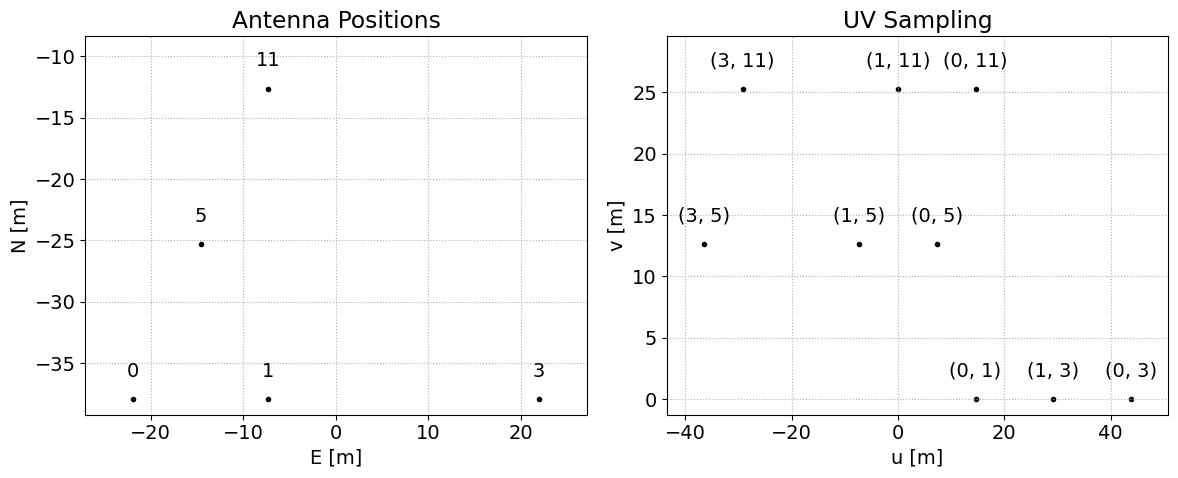

In [10]:
antpos, antnums = uvd_sum.get_enu_data_ants()

blids = np.unique(uvd_sum.baseline_array)
antpairs = [uvd_sum.baseline_to_antnums(blid) for blid in blids]
uvws = np.zeros((uvd_sum.Nbls, 3), dtype=float)
for i_bl, antpair in enumerate(antpairs):
    uvws[i_bl] = uvd_sum.uvw_array[uvd_sum.antpair2ind(antpair).start]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

ax = axs[0]
ax.set_title('Antenna Positions')
ax.set_ylabel('N [m]')
ax.set_xlabel('E [m]')
for ((e, n, u), antnum) in zip(antpos, antnums):
    ax.scatter(e, n, marker='.', color='k')
    ax.annotate(antnum, (e, n+1.5), ha='center', va='bottom')

ax = axs[1]
ax.set_title('UV Sampling')
ax.set_ylabel('v [m]')
ax.set_xlabel('u [m]')
for ((u, v, w), antpair) in zip(uvws, antpairs):
    ax.scatter(u, v, marker='.', color='k')
    ax.annotate(antpair, (u, v+1.5), ha='center', va='bottom')

for ax in axs:
    ax.grid()
    ax.set_ylim(np.array(ax.get_ylim()) + np.array([0, 3]))
    ax.set_xlim(np.array(ax.get_xlim()) + np.array([-3, 3]))
fig.tight_layout();

**Figure 1:** (Left) Antenna positions in East-North-Up units.  (Right) UV sampling of the baselines included in the simulations.

# Calculate expected EoR delay power spectrum and covariance for each baseline

In [11]:
if Npriorbins > 0:
    ps_prior_inds = slice(
        Nfreqs//2 - Npriorbins,
        Nfreqs//2 + Npriorbins + 1
    )
else:
    ps_prior_inds = []

eor_dps_dict = {}
eor_cov_dict = {}
eor_dps_priors_dict = {}

# Delay bin centers in nanoseconds
delays = np.fft.fftshift(np.fft.fftfreq(Nfreqs, d=df.to("1/ns")))

# Discrete Fourier transform matrix for frequency to delay
dft_mat = hydra_pspec.utils.fourier_operator(Nfreqs)

for i_bl, antpair in enumerate(antpairs):
    # Delay power spectrum of the mock EoR visibilities
    eor_dps_dict[antpair] = calc_naive_dps(
        uvd_eor.get_data(antpair + ('pI',), force_copy=True),
        freqs,
        vis_unit=vis_unit,
        norm=False
    )

    # EoR covariance matrix estimate
    eor_cov_dict[antpair] = 1 / Nfreqs**2 * (
        dft_mat.conj().T
        @ np.diag(eor_dps_dict[antpair].mean(axis=0))
        @ dft_mat
    )

    # EoR delay power spectrum priors
    priors = np.zeros((2, Nfreqs), dtype=float)
    if Npriorbins > 0:
        priors[0, ps_prior_inds] = prior_buffer * (
            eor_dps_dict[antpair].mean(axis=0).max().value
        )
        priors[1, ps_prior_inds] = (1/prior_buffer) * (
            eor_dps_dict[antpair].mean(axis=0).min().value
        )
    eor_dps_priors_dict[antpair] = priors

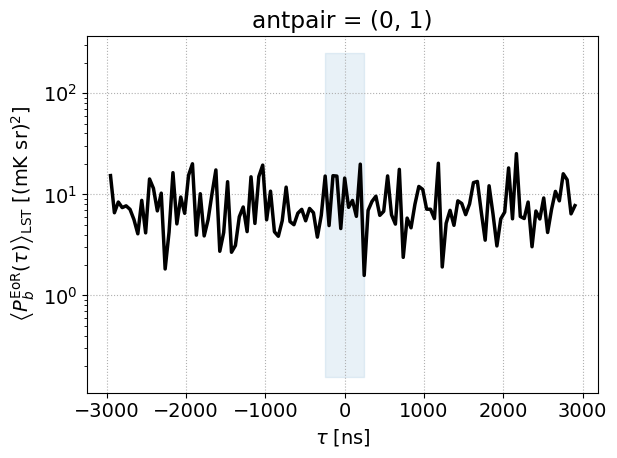

In [12]:
antpair = (0, 1)

fig, ax = plt.subplots()
ax.set_title(f"{antpair = }")
ax.set_ylabel(
    r"$\left< P_b^{\rm{EoR}}(\tau) \right>_{\rm{LST}}$ " 
    fr"[({vis_unit})$^2$]"
)
ax.set_xlabel(r"$\tau$ [ns]")
ax.plot(delays, eor_dps_dict[antpair].mean(axis=0), "k-")
prior_lo = eor_dps_priors_dict[antpair][:, ps_prior_inds][1, 0]
prior_hi = eor_dps_priors_dict[antpair][:, ps_prior_inds][0, 0]
ax.fill_between(
    delays[ps_prior_inds][[0, -1]].value,
    np.ones(2)*prior_lo,
    np.ones(2)*prior_hi,
    color="C0",
    alpha=0.1
)
ax.grid()
ax.set_yscale("log")
fig.tight_layout();

**Figure 2:** Example (time-averaged) delay power spectrum for a antenna pair (0, 1) (14.6 m EW baseline) in black.  The mock EoR sky model used in the simulations is white noise and the corresponding power spectrum is flat in delay.  The blue shaded region marks the prior bounds for the central delay bins with priors.

# Generate noise visibilities and covariance matrices for each baseline

The visibility simulations are noise free.  We thus need to simulate noise and estimate the noise covariance matrix for each baseline.  For purposes of this demonstration, we simulated Gaussian noise with an amplitude set such that the EoR delay power spectrum for each baseline should have an average signal-to-noise (SNR) ratio of 10 relative to the noise in delay power spectrum space.

In [13]:
noise_vis_dict = {}
noise_cov_dict = {}
dps_dict_noise = {}

# Generate random seeds for the noise visibility generation
np.random.seed(912834)
random_seeds = np.random.randint(1, 9999999, (len(antpairs), 2))

for i_bl, antpair in enumerate(antpairs):
    # Calculate the desired noise delay PS amplitude
    noise_dps_amp = eor_dps_dict[antpair].mean() / snr_dps

    # Calculate the standard deviation of the noise in the
    # visibility domain corresponding to the desired noise
    # delay PS amplitude (noise_dps_amp) via Parseval's theorem
    noise_var_vis = noise_dps_amp.copy() / Nfreqs  # / df.to('Hz').value
    noise_stddev_vis = np.sqrt(noise_var_vis)

    # Make noise covariance matrix
    noise_cov = np.eye(Nfreqs) * noise_stddev_vis.to(vis_unit).value**2
    noise_cov_dict[antpair] = noise_cov

    # Draw Gaussian random noise using the calculated stddev
    np.random.seed(random_seeds[i_bl, 0])
    noise_real = np.random.normal(
        0,
        noise_stddev_vis.to(vis_unit).value / np.sqrt(2),
        eor_dps_dict[antpair].shape
    )
    np.random.seed(random_seeds[i_bl, 1])
    noise_imag = np.random.normal(
        0,
        noise_stddev_vis.to(vis_unit).value / np.sqrt(2),
        eor_dps_dict[antpair].shape
    )
    noise = noise_real + 1j*noise_imag
    noise_vis_dict[antpair] = noise
    dps_dict_noise[antpair] = calc_naive_dps(
        noise, freqs, norm=False, vis_unit=vis_unit
    )

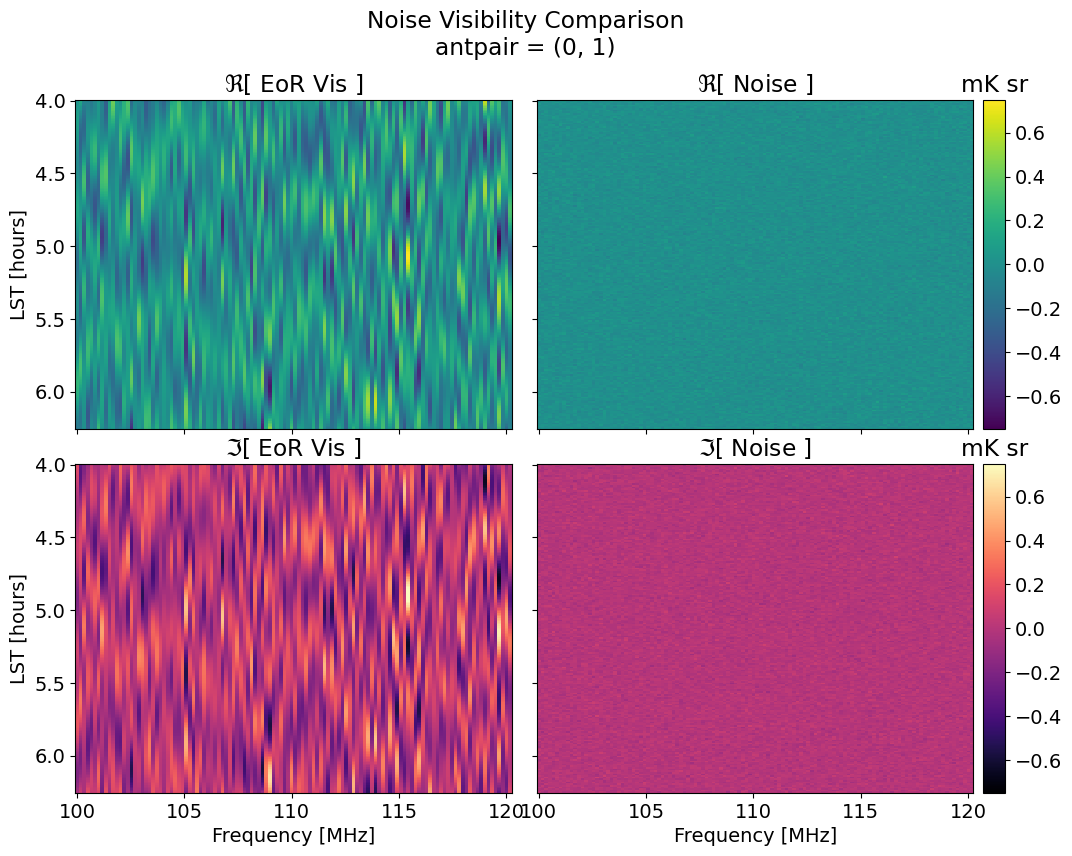

In [14]:
i_bl = 0
antpair = antpairs[i_bl]
vis = uvd_eor.get_data(antpair + ("pI",))
noise = noise_vis_dict[antpair]
extent = extent_freq + extent_lst[::-1]

fig = plt.figure(figsize=(12, 9))
grid = ImageGrid(
    fig, 111, (2, 2), axes_pad=(0.25, 0.35), aspect=False,
    cbar_mode='edge', cbar_pad=0.1
)

clim = np.max(
    (np.abs(uvd_eor.get_data(antpair + ("pI",)).real),
     np.abs(noise_vis_dict[antpair].real))
)
ax = grid.axes_row[0][0]
ax.set_title(r"$\Re$[ EoR Vis ]")
im = ax.imshow(
    uvd_eor.get_data(antpair + ("pI",)).real, extent=extent, aspect="auto",
    vmin=-clim, vmax=clim
)
cb = fig.colorbar(im, cax=ax.cax)
cb.ax.set_title(vis_unit)

ax = grid.axes_row[0][1]
ax.set_title(r"$\Re$[ Noise ]")
im = ax.imshow(
    noise_vis_dict[antpair].real, extent=extent, aspect="auto",
    vmin=-clim, vmax=clim
)
cb = fig.colorbar(im, cax=ax.cax)
cb.ax.set_title(vis_unit)

clim = np.max(
    (np.abs(uvd_eor.get_data(antpair + ("pI",)).real),
     np.abs(noise_vis_dict[antpair].real))
)
ax = grid.axes_row[1][0]
ax.set_title(r"$\Im$[ EoR Vis ]")
im = ax.imshow(
    uvd_eor.get_data(antpair + ("pI",)).imag, extent=extent, aspect="auto",
    vmin=-clim, vmax=clim, cmap="magma"
)
cb = fig.colorbar(im, cax=ax.cax)
cb.ax.set_title(vis_unit)

ax = grid.axes_row[1][1]
ax.set_title(r"$\Im$[ Noise ]")
im = ax.imshow(
    noise_vis_dict[antpair].imag, extent=extent, aspect="auto",
    vmin=-clim, vmax=clim, cmap="magma"
)
cb = fig.colorbar(im, cax=ax.cax)
cb.ax.set_title(vis_unit)

for ax in grid.axes_column[0]:
    ax.set_ylabel("LST [hours]")
for ax in grid.axes_row[1]:
    ax.set_xlabel("Frequency [MHz]")

fig.suptitle(
    "Noise Visibility Comparison\n"
    + f"antpair = {antpair}"
);

**Figure 3:** EoR (left) and noise visibility waterfalls (right) for antenna pair (0, 1) (14.6 m EW baseline).  The top (bottom) row plots the real (imaginary) component of the EoR and noise visibilities on the same colorscale for comparison.

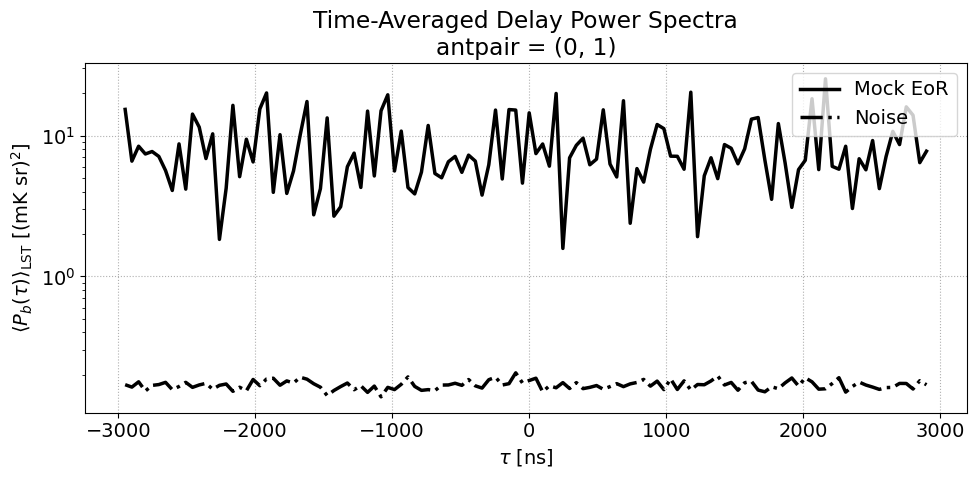

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(
    "Time-Averaged Delay Power Spectra\n"
    + f"antpair = {antpairs[i_bl]}"
)
ax.set_ylabel(
    r"$\left< P_b(\tau) \right>_{\rm{LST}}$ " 
    fr"[({vis_unit})$^2$]"
)
ax.set_xlabel(r"$\tau$ [ns]")
ax.plot(
    delays.to("ns"),
    eor_dps_dict[antpairs[i_bl]].mean(axis=0),
    "k-",
    label="Mock EoR"
)
dps_noise = calc_naive_dps(
    noise_vis_dict[antpairs[i_bl]],
    freqs,
    norm=False,
    vis_unit=vis_unit
)
ax.plot(
    delays.to("ns"),
    dps_noise.mean(axis=0),
    "k-.",
    label="Noise"
)
ax.set_yscale("log")
ax.grid()
ax.legend(loc="upper right")
fig.tight_layout();

**Figure 4:** Time-averaged EoR (solid) and noise (dash-dot) delay power spectra for a antenna pair (0, 1) (14.6 m EW baseline).  We can see that the average SNR over the entire delay range is ~10, our desired SNR in delay power spectrum space.

# Generate foreground model basis vectors for each baseline

The foreground model is composed of a set of spectral basis functions which are fit for independently at each time sample.  These spectral basis vectors can be calculated as eigenvectors of a freq-freq covariance matrix of the foreground visibilities.  This is a luxury we are afforded when using simulated visibilities as we can extract the foreground only components.  However, this type of analysis should still be valid as foregrounds will dominate the underlying EoR signal in the visibilities and the leading principle components should correspond to the foregrounds in the visibilities.

In [16]:
fgmodes_dict = {}
evals_dict = {}

for antpair in antpairs:
    vis = uvd_fgs.get_data(antpair + ("pI",), force_copy=True)
    cov = np.cov(vis.T)
    evals, evecs = np.linalg.eig(cov)
    eigspec_diff = np.diff(np.abs(evals))
    Nfgmodes = np.where(np.abs(eigspec_diff) < 1e-8)[0][0] + 1
    fgmodes_dict[antpair] = evecs[:, :Nfgmodes]
    evals_dict[antpair] = evals

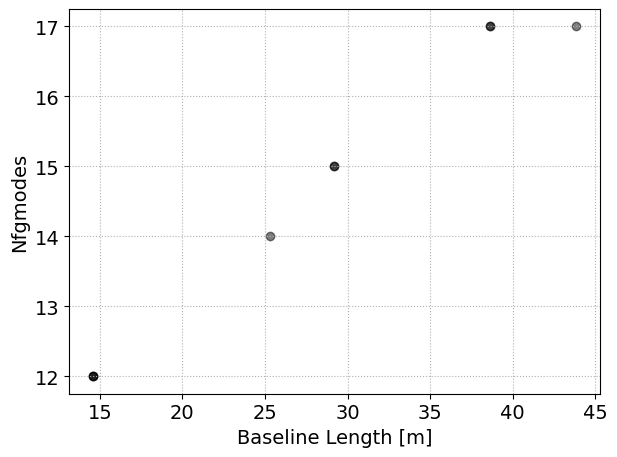

In [17]:
bl_lens = np.sqrt(np.sum(uvws**2, axis=1)) * units.m
unique_bl_lens, bl_lens_inds = np.unique(np.round(bl_lens, decimals=1), return_inverse=True)

fig, ax = plt.subplots()
ax.set_ylabel("Nfgmodes")
ax.set_xlabel(r"Baseline Length [m]")
for i_b, b in enumerate(unique_bl_lens):
    for antpair in np.array(antpairs)[bl_lens_inds == i_b]:
        ax.scatter(
            b.value, fgmodes_dict[tuple(antpair)].shape[1],
            marker="o", color="k", alpha=0.5
        )
ax.grid()
fig.tight_layout();

**Figure 5:** Number of foreground modes used for the foreground model as a function of baseline length.  The number of foregrounds modes used by a single baseline is plotted as a semi-transparent black circle.  In this case, all baselines with a particular baseline length use an identical number of foreground modes.  Generally speaking, the number of foreground modes increases as a function of baseline length.  This is due to the width of the foreground wedge increasing as a function of baseline length.  More foreground modes are ultimately required to adequately model the wedge.

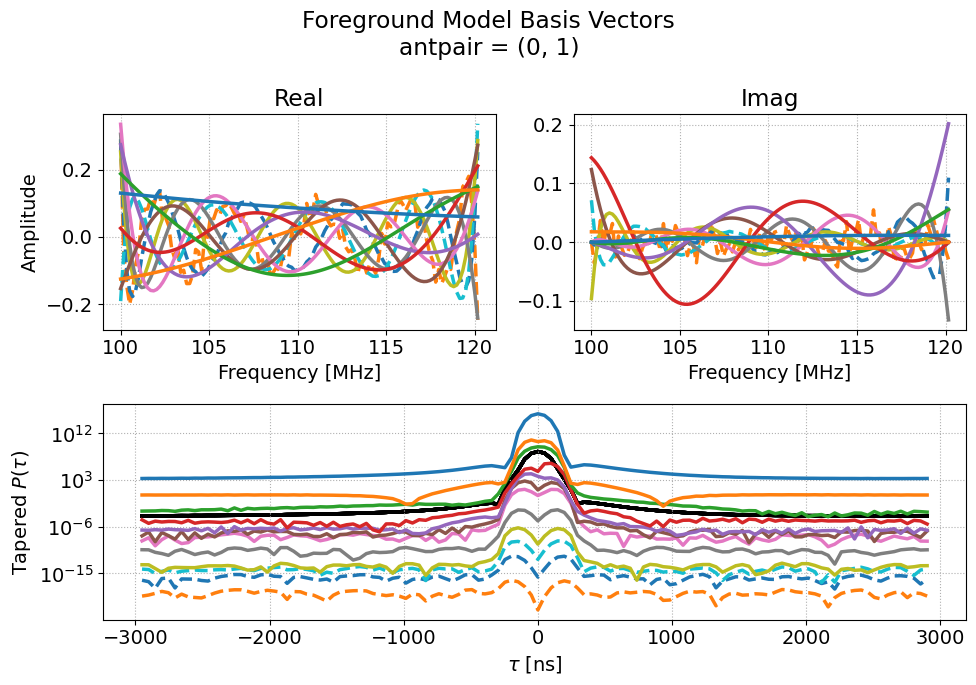

In [18]:
i_bl = 0
antpair = antpairs[i_bl]

fig = plt.figure(figsize=(10, 7))
fig.suptitle(
    "Foreground Model Basis Vectors\n"
    + f"antpair = {antpair}"
)
gs = GridSpec(2, 2, figure=fig)

ax_re = fig.add_subplot(gs[0, 0])
ax_re.set_title("Real")
ax_re.set_ylabel("Amplitude")

ax_im = fig.add_subplot(gs[0, 1])
ax_im.set_title("Imag")

for ax in [ax_re, ax_im]:
    ax.set_xlabel("Frequency [MHz]")

ax_dps = fig.add_subplot(gs[1, :])
ax_dps.set_ylabel(rf"Tapered $P(\tau)$")
ax_dps.set_xlabel(r"$\tau$ [ns]")
ax_dps.set_yscale("log")

for i_mode, fgmode in enumerate(fgmodes_dict[antpair].T):
    if i_mode < 9:
        ls_str = f"C{i_mode}-"
    else:
        ls_str = f"C{i_mode}--"
    ax_re.plot(freqs.to("MHz"), fgmode.real, ls_str, zorder=Nfgmodes-i_mode)
    ax_im.plot(freqs.to("MHz"), fgmode.imag, ls_str, zorder=Nfgmodes-i_mode)

    amp = evals_dict[antpair][i_mode]
    dps_fgmode = calc_naive_dps(amp*fgmode, freqs, axis=0, taper=True)
    ax_dps.plot(delays.to("ns"), dps_fgmode, ls_str, zorder=Nfgmodes-i_mode)

    dps_fgs = calc_naive_dps(
        uvd_fgs.get_data(antpair + ("pI",), force_copy=True),
        freqs,
        axis=1,
        taper=True
    )
    ax_dps.plot(delays.to("ns"), dps_fgs.mean(axis=0), "k-", zorder=0)
for ax in fig.axes:
    ax.grid()
gs.tight_layout(fig);

**Figure 6:** (Top) Real (left) and imaginary (right) components of the foreground model basis vectors for antenna pair (0, 1) (14.6 m EW baseline).  This plot uses the default matplotlib color sequence but if there are more than 10 foreground model basis vectors, the color cycle is repeated but with dashed lines.  (Bottom) Blackman-Harris tapered delay power spectra of each foreground model basis vector multiplied by its corresponding eigenvalue.  The tapering help illustrate that successive eigenvectors spread out from $\tau=0$ ns to higher delays to fill out the foreground wedge. and many basis vectors are required to adequately sample the foreground wedge.  The tapered delay power spectrum of the foreground visibilities is plotted in the background as the solid black line for reference.

# Make example flagging pattern

For the time being, we are required to use time-independent flags.  This will change in the future so we can accomodate time-dependent flags in `hydra-pspec`.

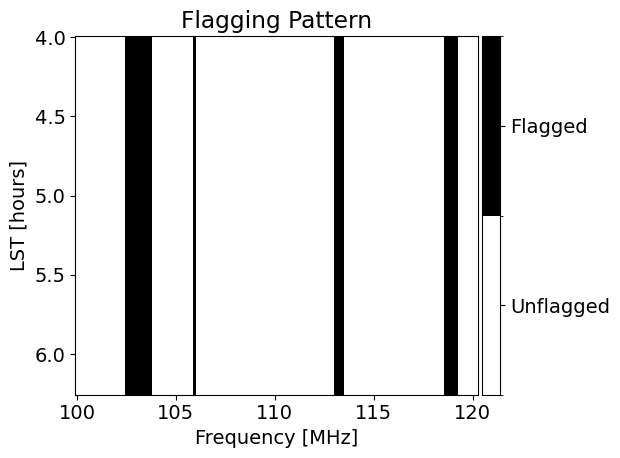

In [19]:
flags = np.zeros((Ntimes, Nfreqs), dtype=bool)
flags[:, 15:23] = True
flags[:, 35] = True
flags[:, 77:80] = True
flags[:, 110:114] = True

cmap = plt.cm.bone_r
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N
)
bounds = np.linspace(0, 2, 3)
norm = BoundaryNorm(bounds, cmap.N)

extent = extent_freq + extent_lst[::-1]

fig, ax = plt.subplots()
ax.set_title("Flagging Pattern")
ax.set_ylabel("LST [hours]")
ax.set_xlabel("Frequency [MHz]")
im = ax.imshow(
    flags.astype(int), cmap=cmap, norm=norm, extent=extent, aspect="auto"
)
cb = fig.colorbar(im, ax=ax, pad=0.01)
cb.set_ticks([0.5, 1.5], labels=["Unflagged", "Flagged"])
fig.tight_layout();

**Figure 7:** Flagging pattern used in this analysis.  The distribution of flags was arbitrarily chosen but a selection of flagging gap widths has been used.

# Run the sampler

In [20]:
# Set to True for debug information for each sample
verbose = False

results_dict = {}

# Generate random seeds for the noise visibility generation
np.random.seed(186792)
random_seeds = np.random.randint(1, 9999999, len(antpairs))

for seed, antpair in zip(random_seeds, antpairs):
    print(
        f"Antenna pair {antpair}" + "\n" + "-"*len(f"Antenna pair {antpair}")
    )
    print("Generating power spectrum samples...")
    if verbose:
        print()
    start = time.time()

    res = hydra_pspec.pspec.gibbs_sample_with_fg(
        uvd_sum.get_data(antpair + ("pI",), force_copy=True),
        np.logical_not(flags[0]),
        eor_cov_dict[antpair],
        fgmodes_dict[antpair],
        np.linalg.inv(noise_cov_dict[antpair]),
        eor_dps_priors_dict[antpair],
        Niter=Nsamples,
        seed=seed,
        verbose=False,
        nproc=1,
        write_Niter=Nsamples*2
    )
    results_dict[antpair] = {
        "gcr_eor": res[0],
        "cov_eor": res[1],
        "dps_eor": res[2],
        "fg_amps": res[3]
    }
    elapsed = time.time() - start
    print(
        f"Elapsed time to generate {Nsamples} samples = {elapsed} s",
        end="\n\n"
    )

Antenna pair (0, 1)
-------------------
Generating power spectrum samples...
Elapsed time to generate 100 samples = 32.004825592041016 s

Antenna pair (0, 3)
-------------------
Generating power spectrum samples...
Elapsed time to generate 100 samples = 26.25063920021057 s

Antenna pair (0, 5)
-------------------
Generating power spectrum samples...
Elapsed time to generate 100 samples = 31.954111576080322 s

Antenna pair (0, 11)
--------------------
Generating power spectrum samples...
Elapsed time to generate 100 samples = 26.276729822158813 s

Antenna pair (1, 3)
-------------------
Generating power spectrum samples...
Elapsed time to generate 100 samples = 26.43581533432007 s

Antenna pair (1, 5)
-------------------
Generating power spectrum samples...
Elapsed time to generate 100 samples = 32.27565145492554 s

Antenna pair (1, 11)
--------------------
Generating power spectrum samples...
Elapsed time to generate 100 samples = 26.371159553527832 s

Antenna pair (3, 5)
-------------

In [21]:
# Assume Gaussianity of posteriors for now to make uncertainty
# propagation simple.  A more detailed treatment is required in
# practice as posteriors are not gauranteed to be Gaussian and
# can in some cases be e.g. skewed.

dps_dict = {}

for antpair in antpairs:
    dps_est = results_dict[antpair]["dps_eor"]
    dps_dict[antpair] = {
        "mean": dps_est.mean(axis=0),
        "std": dps_est.std(axis=0)
    }

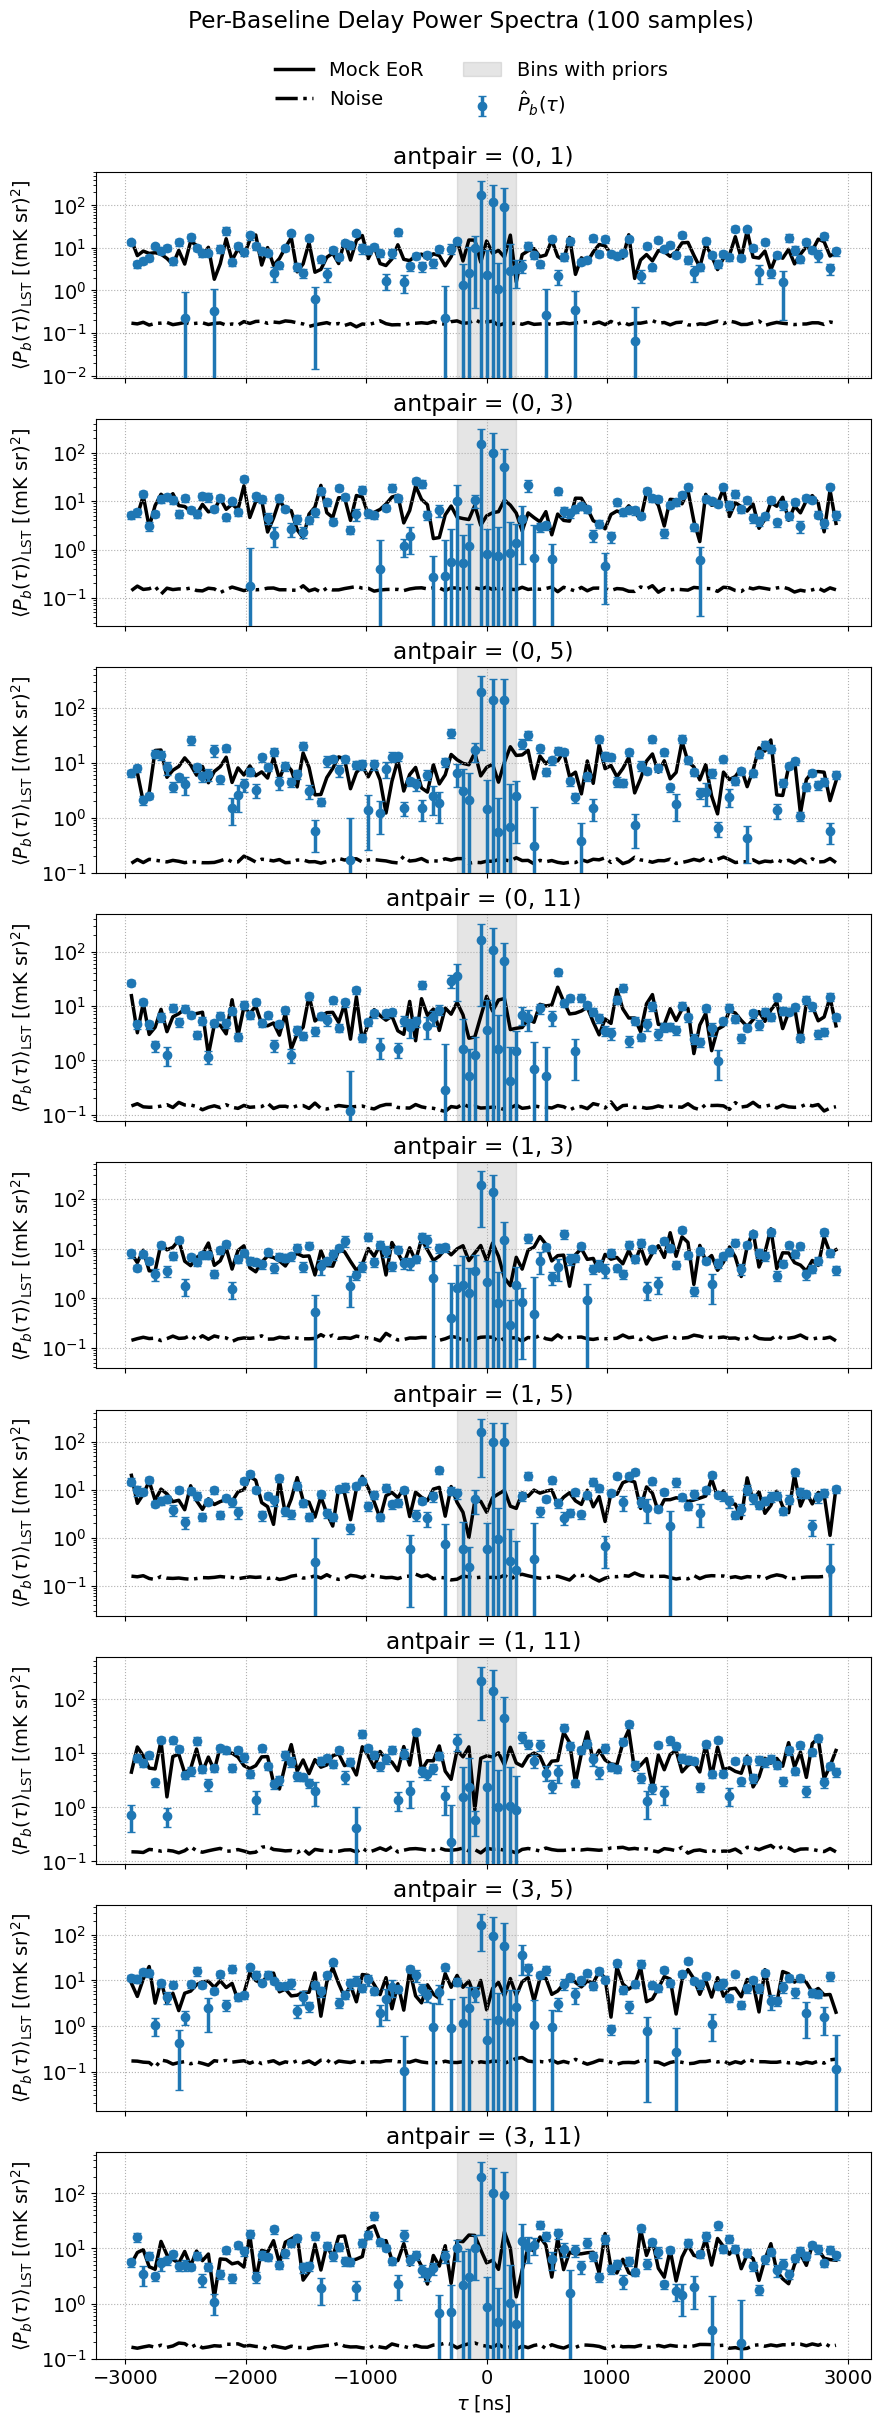

In [22]:
# Plot the delay power spectrum summary statistics for a subset of baselines
antpairs_plot = antpairs.copy()

nrows = len(antpairs_plot)
fig, axs = plt.subplots(
    nrows, 1, sharex=True, figsize=(10, nrows*3), gridspec_kw={"hspace": 0.2}
)
fig.suptitle(
    f"Per-Baseline Delay Power Spectra ({Nsamples} samples)"
)

for i_ax, antpair in enumerate(antpairs_plot):
    ax = axs[i_ax]
    ax.set_title(f"{antpair = }")
    ax.set_ylabel(
        fr"$\left< P_b(\tau) \right>_{{\rm{{LST}}}}$ [({vis_unit})$^2$]"
    )
    
    ax.plot(
        delays.to("ns"),
        eor_dps_dict[antpair].mean(axis=0),
        "k-",
        zorder=1,
        label="Mock EoR"
    )
    dps_noise = calc_naive_dps(noise_vis_dict[antpair], freqs, norm=False)
    ax.plot(
        delays.to("ns"),
        dps_noise.mean(axis=0),
        "k-.",
        zorder=1,
        label="Noise"
    )
    ax.errorbar(
        delays.to("ns"),
        dps_dict[antpair]["mean"],
        yerr=2*dps_dict[antpair]["std"],
        color="C0",
        marker="o",
        ls="",
        capsize=3,
        zorder=5,
        label=fr"$\hat{{P}}_b(\tau)$"
    )
    if Npriorbins > 0:
        ax.axvspan(
            *delays[ps_prior_inds][[0, -1]].to("ns").value,
            color="0.5",
            alpha=0.2,
            label="Bins with priors",
            zorder=0
        )
    ax.grid()
    ax.set_yscale("log")
ax.set_xlabel(r"$\tau$ [ns]")

# fig.tight_layout()
if Npriorbins > 0:
    ncol = 2
    top = 0.92
else:
    ncol = 3
    top = 0.95
fig.subplots_adjust(top=top)
fig.legend(
    *axs[0].get_legend_handles_labels(),
    ncol=ncol,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9675),
    loc="upper center"
);

**Figure 8:** Recovered delay power spectrum summary statistics plot for each baseline (one baseline per row).  The ultimate output of `hydra-pspec` is a posterior for each delay bin.  Here we only show the mean and standard deviation as blue data points with errorbars (2 standard deviations).  We only have a modest number of samples here (Nsamples = 100).  More samples are required for better posteriors.  Regardless, we can see a large number of estimates are consistent with the input EoR delay power spectrum (solid black lines) with only 100 samples.

# Cylindrically average results

In [23]:
# Cosmological delay power spectrum normalizations
cosmo = Planck18
f_21 = 1420.40575177 * units.MHz  # 21 cm rest-frame frequency
z = (f_21/freqs.mean().to("MHz") - 1).value  # redshift
wavelength_mean = c.to("m/s") / freqs.mean().to("1/s")

# Comoving transverse distance per radian in Mpc
dl_dth = cosmo.comoving_transverse_distance(z) / units.rad
# Comoving differential distance at redshift per frequency
d_h = c.to("km/s") / cosmo.H0
e_z = cosmo.efunc(z)
dl_df = d_h / e_z * (1 + z)**2 / f_21.to("Hz")

# Beam normalization
# The simulations use an Airy disk as the antenna beam pattern.
# We use the AiryBeam class here to numerically compute the
# integral of the beam squared for the delay power spectrum
# normalization.
beam = AiryBeam(diameter=14.2)
beam = beam.to_uvbeam(freqs.to("Hz").value, nside=64)
beam.efield_to_pstokes()
beam.peak_normalize()
# Naive guess for du -> dk_perp of half the aperture function
# which for an Airy beam is a circle with diameter equal to
# the dish diameter of 14.2 m.
du = 14.2 * units.m
du /= wavelength_mean * units.rad
dk_perp = 2*np.pi*du / dl_dth

bandwidth = Nfreqs * df.to("Hz")
# Line-of-sight axis Fourier resolution
ddelay = 1 / bandwidth
dk_para = 2*np.pi*ddelay / dl_df

# Integral of the beam squared
omega_pp = beam.get_beam_sq_area() * units.sr

In [24]:
u_bins = du * np.arange(
    int(np.floor((bl_lens.min() / wavelength_mean).value / du.value)),
    int(np.ceil((bl_lens.max() / wavelength_mean).value / du.value))
)
u_bins_edges = du.unit * np.arange(
    (u_bins.min() - du/2).value, (u_bins.max() + du).value, du.value
)

delay_bins = ddelay * np.arange(Nfreqs//2 + ((Nfreqs//2 % 2) == 0))
delay_bins_edges = ddelay.unit * np.arange(
    (delay_bins.min() - ddelay/2).value,
    (delay_bins.max() + ddelay).value,
    ddelay.value
)

k_perp_bins = u_bins / du * dk_perp
k_perp_edges = u_bins_edges / du * dk_perp
extent_k_perp = list(k_perp_edges[[0, -1]].value)

k_para_bins = delay_bins / ddelay * dk_para
k_para_edges = delay_bins_edges / ddelay * dk_para
extent_k_para = list(k_para_edges[[0, -1]].value)

delay_horizons = u_bins_edges * wavelength_mean * units.rad / c.to("m/ns")
k_para_horizons = delay_horizons.to("1/Hz") / ddelay * dk_para

In [25]:
# Cylindrical delay power spectra for the EoR
dps_2d = np.zeros((u_bins.size, delay_bins.size), dtype=float)
dps_2d_err = np.zeros_like(dps_2d)
# Cylindrical delay power spectra of the input EoR visibilities
dps_2d_eor = np.zeros_like(dps_2d)
# Cylindrical delay power spectra for the noise
dps_2d_noise = np.zeros_like(dps_2d)

for i_u in range(u_bins.size):
    bl_inds = np.logical_and(
        (bl_lens/wavelength_mean).value >= u_bins_edges[i_u].value,
        (bl_lens/wavelength_mean).value <= u_bins_edges[i_u + 1].value
    )
    bl_inds = np.where(bl_inds)[0]
    bl_antpairs = [antpairs[i] for i in bl_inds if antpairs[i] in antpairs]

    if len(bl_antpairs) > 0:
        # Average delay bins at -tau and tau to "fold"
        # spectra to positive delay bins only
        dps_bls_folded = np.zeros(
            (len(bl_antpairs), Nfreqs//2 + ((Nfreqs//2 % 2) == 0)), dtype=float
        )
        dps_err_bls_folded = np.zeros_like(dps_bls_folded)
        dps_bls_folded_eor = np.zeros_like(dps_bls_folded)
        dps_bls_folded_noise = np.zeros_like(dps_bls_folded)
        for i_bl, antpair in enumerate(bl_antpairs):
            for i_tau, tau in enumerate(np.unique(np.abs(delays))):
                tau_inds = np.abs(delays) == tau
                dps_bls_folded[i_bl, i_tau] = np.mean(
                    dps_dict[antpair]["mean"][tau_inds]
                )
                dps_err_bls_folded[i_bl, i_tau] = np.mean(
                    dps_dict[antpair]["std"][tau_inds]
                )
                dps_bls_folded_eor[i_bl, i_tau] = np.mean(
                    eor_dps_dict[antpair].mean(axis=0)[tau_inds].value
                )
                dps_bls_folded_noise[i_bl, i_tau] = np.mean(
                    dps_dict_noise[antpair].mean(axis=0)[tau_inds].value
                )
    dps_2d[i_u] = np.mean(dps_bls_folded, axis=0)
    dps_2d_err[i_u] = np.sqrt(np.mean(dps_err_bls_folded**2, axis=0))
    dps_2d_eor[i_u]= np.mean(dps_bls_folded_eor, axis=0)
    dps_2d_noise[i_u] = np.mean(dps_bls_folded_noise, axis=0)

dps_norm = (
    # Re-apply data units
    (units.mK * units.sr)**2
    # hydra-pspec currently calculates delay power spectra in data units
    # squared, but delay power spectra in instrumental units should have
    # units of Jy^2 Hz^2.  These units are important when converting to
    # cosmological units thus we pre-multiply the "typical" delay power
    # spectrum normalization from e.g. equation 12 in Parsons et al. 2012.
    * df.to("Hz")**2
    # The "typical" delay power spectrum normalization
    * (dl_dth**2).to("Mpc^2/sr") * dl_df / (omega_pp.mean() * bandwidth)
)
dps_2d = dps_2d.T * dps_norm
dps_2d_err = dps_2d_err.T * dps_norm
dps_2d_eor = dps_2d_eor.T * dps_norm
dps_2d_noise = dps_2d_noise.T * dps_norm

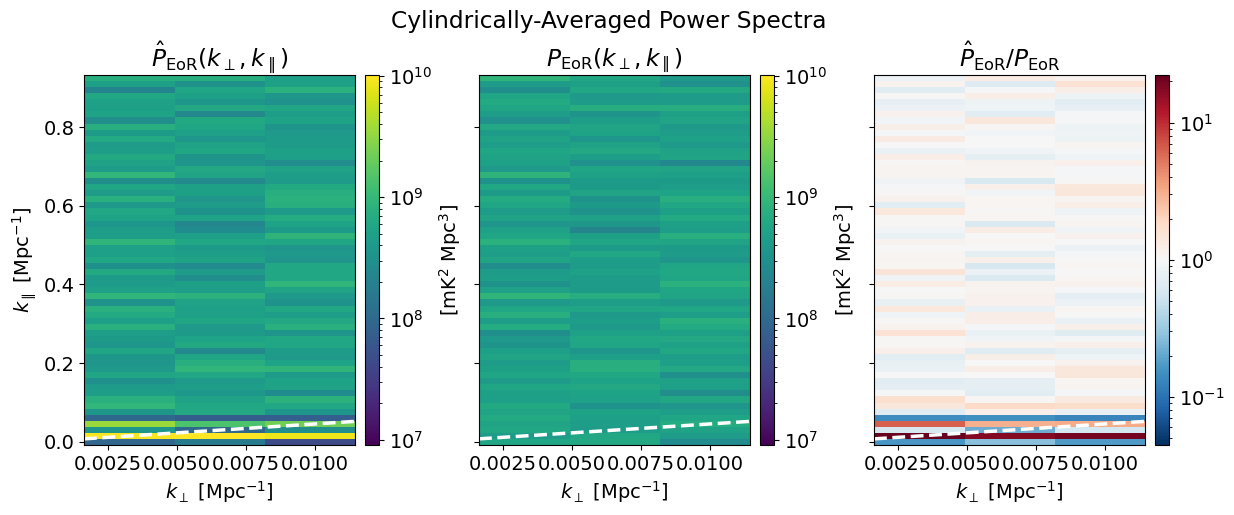

In [26]:
fig = plt.figure(figsize=(14, 5))
grid = ImageGrid(
    fig, 111, (1, 3), share_all=False, axes_pad=1,
    cbar_mode="each", cbar_pad=0.1, aspect=False
)

im_kwargs = dict(
    aspect="auto", origin="lower", extent=extent_k_perp+extent_k_para
)

norm = LogNorm(
    vmin=np.min((dps_2d.min().value, dps_2d_eor.min().value)),
    vmax=np.max((dps_2d.max().value, dps_2d_eor.max().value))
)

ax = grid.axes_all[0]
ax.set_title(r"$\hat{P}_{\rm{EoR}}(k_\perp, k_\parallel)$")
ax.set_ylabel(r"$k_\parallel$ [Mpc$^{-1}$]")
norm = LogNorm(
    vmin=np.min((dps_2d.min().value, dps_2d_noise.min().value)),
    vmax=np.max((dps_2d.max().value, dps_2d_noise.max().value))
)
im = ax.imshow(dps_2d.value, norm=norm, **im_kwargs)
cb = fig.colorbar(im, cax=ax.cax, label=r"[mK$^2$ Mpc$^3$]")

ax = grid.axes_all[1]
ax.set_title(r"$P_{\rm{EoR}}(k_\perp, k_\parallel)$")
im = ax.imshow(dps_2d_eor.value, norm=norm, **im_kwargs)
cb = fig.colorbar(im, cax=ax.cax, label=r"[mK$^2$ Mpc$^3$]")

ax = grid.axes_all[2]
ax.set_title(r"$\hat{P}_{\rm{EoR}} / P_{\rm{EoR}}$")
ratio = dps_2d.value / dps_2d_eor.value
clim = np.max((ratio.max(), 1 / ratio.min()))
im = ax.imshow(
    ratio, cmap="RdBu_r", norm=LogNorm(vmin=1/clim, vmax=clim),
    **im_kwargs
)
cb = fig.colorbar(im, cax=ax.cax)

for ax in grid.axes_all:
    ax.set_xlabel(r"$k_\perp$ [Mpc$^{-1}$]")
    ax.plot(k_perp_edges, k_para_horizons, "w--")

fig.subplots_adjust(top=0.85)
fig.suptitle("Cylindrically-Averaged Power Spectra");

**Figure 9:** Two-dimensional (cylindrically-averaged) delay power spectrum estimates from `hydra-pspec` (left) compared to the input EoR visibilities (center).  The right plot displays the ratio of the estimated power spectrum to the input power spectrum (left column divided by middle column).  The white dashed line marks the edge of the foreground wedge for reference.

# Spherically average results

In [27]:
# Spherically bin the cylindrically binned power spectra
# in shells of k = sqrt(k_perp**2 + k_para**2).
k_perp_mg, k_para_mg = np.meshgrid(k_perp_bins, k_para_bins)
dk = 5*np.sqrt(dk_perp**2 + dk_para**2)
k_bins_cyl = np.sqrt(k_perp_mg**2 + k_para_mg**2)
Nkbins = int(np.ceil(k_bins_cyl.max() / dk))
k_bins = np.linspace(k_bins_cyl.min(), k_bins_cyl.max(), Nkbins)
k_bins_edges = np.linspace(k_bins.min() - dk/2, k_bins.max() + dk/2, Nkbins+1)

dps_1d = dps_2d.unit * np.zeros(Nkbins, dtype=float)
dps_1d_std = np.zeros_like(dps_1d)
dps_1d_eor = np.zeros_like(dps_1d)
dps_1d_noise = np.zeros_like(dps_1d)
Nksummed = 0
for i_k in range(Nkbins):
    k_mask = np.logical_and(
        k_bins_cyl >= k_bins_edges[i_k],
        k_bins_cyl < k_bins_edges[i_k+1]
    )
    Nksummed += k_mask.sum()
    dps_1d[i_k] = np.mean(dps_2d[k_mask])
    dps_1d_std[i_k] = np.sqrt(np.mean(dps_2d_err[k_mask]**2))
    dps_1d_eor[i_k] = np.mean(dps_2d_eor[k_mask])
    dps_1d_noise[i_k] = np.mean(dps_2d_noise[k_mask])

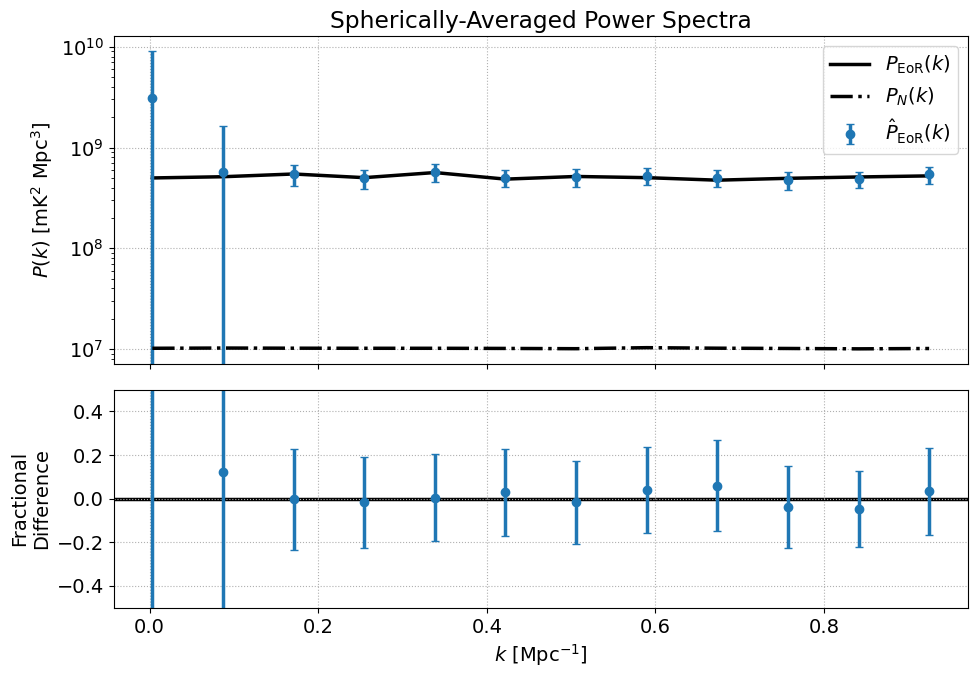

In [28]:
fig, axs = plt.subplots(
    2, 1, sharex=True, figsize=(10, 7), gridspec_kw={"height_ratios": [1.5, 1]}
)

ax = axs[0]
ax.set_title("Spherically-Averaged Power Spectra")
ax.set_ylabel(r"$P(k)$ [mK$^2$ Mpc$^3$]")
ax.plot(k_bins, dps_1d_eor, "k-", label=r"$P_{\rm{EoR}}(k)$")
ax.errorbar(
    k_bins, dps_1d, yerr=2*dps_1d_std, color="C0",
    marker="o", capsize=3, ls="", label=r"$\hat{P}_{\rm{EoR}}(k)$"
)
ax.plot(k_bins, dps_1d_noise, "k-.", label=r"$P_{N}(k)$")
ax.set_yscale("log")
ax.legend()

ax = axs[1]
ax.set_ylabel("Fractional\nDifference")
ax.set_xlabel(r"$k$ [Mpc$^{-1}$]")
ax.errorbar(
    k_bins, dps_1d/dps_1d_eor - 1, yerr=2*dps_1d_std/dps_1d_eor,
    color="C0", marker="o", capsize=3, ls=""
)
ax.axhline(0, color="k", ls="-", zorder=0)
ax.set_ylim([-0.5, 0.5])

for ax in axs:
    ax.grid()
fig.tight_layout();

**Figure 10:** One-dimensional (spherically-averaged) power spectra.  The solid line plots the power spectrum of the input EoR visibilities.  The data points with errorbars represent the results from `hydra-pspec` plotted as the mean plus or minus two standard deviations.  The dash-dot line plots the power spectrum of the noise.  The results from `hydra-pspec` are consistent within errorbars in all $k$ bins.  The two lowest $k$ bins represent non-detections, likely due to residual foreground contamination (especially at $k=0$ Mpc$^{-1}$ where the degeneracy between the EoR and foreground models is maximized).